Load some standard libraries

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor



We will use the following libraties from spacebench.

In [2]:
from spacebench import (
    SpaceEnv,
    SpaceDataset,
    DataMaster,
    DatasetEvaluator,
    EnvEvaluator,
)

Load the datamaster to list available datasets

In [3]:
DataMaster().list_datasets()

['healthd_dmgrcs_mortality_disc',
 'cdcsvi_limteng_hburdic_cont',
 'climate_relhum_wfsmoke_cont',
 'climate_wfsmoke_minrty_disc',
 'healthd_hhinco_mortality_cont',
 'healthd_pollutn_mortality_cont',
 'county_educatn_election_cont',
 'county_phyactiv_lifexpcy_cont',
 'county_dmgrcs_election_disc',
 'cdcsvi_nohsdp_poverty_cont']

Create the environment.

In [4]:
envname = "healthd_dmgrcs_mortality_disc"
env = SpaceEnv(envname, dir="downloads")
env.__dict__.keys()

dict_keys(['name', 'datamaster', 'api', 'dir', 'config', 'synthetic_data', 'metadata', 'graph', 'confounding_score_dict', 'smoothness_score_dict'])

Example of generating a dataset.

In [5]:
dataset = env.make()

In [6]:
dataset = env.make()
print("treatment shape", dataset.treatment.shape)
print("covariates shape", dataset.covariates.shape)
print("num. edges", len(dataset.edges)) 
print("smoothness of missing confounder", dataset.smoothness_of_missing)
print("confounding of missing confounder", dataset.confounding_of_missing)


treatment shape (3109,)
covariates shape (3109, 30)
num. edges 9237
smoothness of missing confounder 0.10762032543841181
confounding of missing confounder 0.0027591117622136965


We can loop over all possible datasets using the make_all method.

Text(0.5, 0.98, 'Distribution of confounding and smoothness')

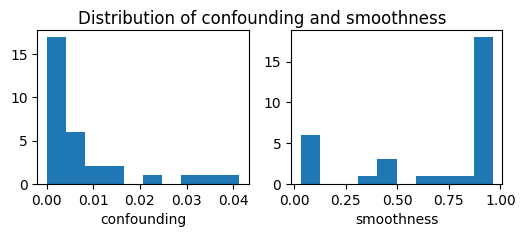

In [7]:
confounding_scores = []
smoothness_scores = []
for dataset in env.make_all():
    confounding_scores.append(dataset.confounding_of_missing)
    smoothness_scores.append(dataset.smoothness_of_missing)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].hist(confounding_scores)
ax[0].set_xlabel("confounding")
ax[1].hist(smoothness_scores)
ax[1].set_xlabel("smoothness")
plt.suptitle("Distribution of confounding and smoothness")

Let's now illustrate how to use the evaluator. On **one** dataset.
We will compare two methods. These methods are not real competitive spatial confounding 
methods, but they are easy to implement and illustrate the use of the evaluator.

One model is a simple xgboost regression model without any type of spatial confounding correction.
The other model uses the coordinates (lon/lats) as features in the model.

In [8]:
def estimate_counterfactuals(model, dataset: SpaceDataset, use_coords: bool):
    """Helper function to fit a model and predict counterfactuals"""
    treatment = dataset.treatment[:, None]
    covariates = dataset.covariates
    outcome = dataset.outcome

    # make train matrix
    trainmat = np.hstack([covariates, treatment])
    if use_coords:
        coords = np.array(dataset.coordinates)
        trainmat = np.hstack([trainmat, coords])

    # fit model
    model.fit(trainmat, outcome)

    # predict counterfactuals
    tvals = dataset.treatment_values
    counterfactuals = []
    for tval in tvals:
        trainmat = np.hstack([covariates, np.full_like(treatment, tval)])
        if use_coords:
            trainmat = np.hstack([trainmat, coords])
        counterfactuals.append(model.predict(trainmat))
    counterfactuals = np.stack(counterfactuals, axis=1)

    return counterfactuals

Now use the `DatasetEvaluator` class.

Errors no coords. ERF: 0.04, PEHE: 2.26
Errors with coords, ERF: 0.02, PEHE: 2.01


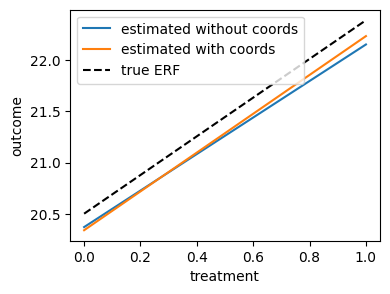

In [9]:
dataset = env.make()
model = XGBRegressor()
model_coords = XGBRegressor()

# generate counterfactuals and estimate exposure response function
cfs = estimate_counterfactuals(model, dataset, use_coords=False)
erf = cfs.mean(0)

cfs_coords = estimate_counterfactuals(model_coords, dataset, use_coords=True)
erf_coords = cfs_coords.mean(0)

# evaluate performance
evaluator = DatasetEvaluator(dataset)

err = evaluator.eval(erf=erf, counterfactuals=cfs)
msg = f"Errors no coords. ERF: {err['erf_av']:.2f}, PEHE: {err['pehe_av']:.2f}"
print(msg)

err_coords = evaluator.eval(erf=erf_coords, counterfactuals=cfs_coords)
msg = f"Errors with coords, ERF: {err_coords['erf_av']:.2f}, PEHE: {err_coords['pehe_av']:.2f}"
print(msg)

# plot comparing estimated and true erf
erf_true = dataset.erf()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(dataset.treatment_values, erf, label="estimated without coords")
ax.plot(dataset.treatment_values, erf_coords, label="estimated with coords")
ax.plot(dataset.treatment_values, erf_true, label="true ERF", linestyle="--", color="k")
ax.set_xlabel("treatment")
ax.set_ylabel("outcome")
ax.legend();

Let us know loop over all datasets and compare the two models. The `EnvEvaluator` evalautor is designed for this task. But we need an evaluator for each model.

In [10]:
# for each masked variable
env_evaluator = EnvEvaluator(env)
env_evaluator_coords = EnvEvaluator(env)

for dataset in tqdm(env.make_all()):
    cfs = estimate_counterfactuals(model, dataset, use_coords=False)
    erf = cfs.mean(0)
    cfs_coords = estimate_counterfactuals(model_coords, dataset, use_coords=True)
    erf_coords = cfs_coords.mean(0)

    err = env_evaluator.add(dataset, erf=erf, counterfactuals=cfs)
    err_coords = env_evaluator_coords.add(
        dataset, erf=erf_coords, counterfactuals=cfs_coords
    )

31it [01:22,  2.65s/it]


On average, it does not seem like including the coordinates helped.

In [11]:
# Average metrics allong the curve
print("Model without coordinates")
summary = env_evaluator.summarize()
print(
    f"PEHE: {summary['pehe'].mean():.2f}",
    f"ERF bias^2: {np.square(summary['erf_bias']).mean():.2f}",
    f"ERF variance: {(summary['erf_variance']).mean():.2f}"
)

print("Model with coordinates")
summary = env_evaluator_coords.summarize()
print(
    f"PEHE: {summary['pehe'].mean():.2f}",
    f"ERF bias^2: {np.square(summary['erf_bias']).mean():.2f}",
    f"ERF variance: {(summary['erf_variance']).mean():.2f}"
)

Model without coordinates
PEHE: 2.13 ERF bias^2: 0.03 ERF variance: 0.00
Model with coordinates
PEHE: 2.15 ERF bias^2: 0.03 ERF variance: 0.00


We may sometimes prefer to use the dataset evaluator and keep metrics in each loop for a more detailed analysis.

In [12]:
# for each masked variable
smoothness_scores = []
confounding_scores = []
erf_error = []
erf_error_coords = []

for dataset in tqdm(env.make_all()):
    evaluator = DatasetEvaluator(dataset)

    cfs = estimate_counterfactuals(model, dataset, use_coords=False)
    erf = cfs.mean(0)
    cfs_coords = estimate_counterfactuals(model_coords, dataset, use_coords=True)
    erf_coords = cfs_coords.mean(0)

    err = evaluator.eval(erf=erf)
    err_coords = evaluator.eval(erf=erf_coords)

    erf_error.append(np.square(err["erf_error"]).mean())
    erf_error_coords.append(np.square(err_coords["erf_error"]).mean())

    smoothness_scores.append(dataset.smoothness_of_missing)
    confounding_scores.append(dataset.confounding_of_missing)

31it [01:13,  2.38s/it]


In [13]:
erf_errors = dict(
    smoothness=["low" if x < 0.5 else "high" for x in smoothness_scores],
    confounding=["low" if x < 0.1 else "high" for x in confounding_scores],
    model_without_coords=erf_error,
    model_with_coords=erf_error_coords,
)
erf_errors = pd.DataFrame(erf_errors)
erf_errors.groupby(["smoothness", "confounding"]).agg(["mean", "std"])

model_without_coords           model_with_coords  \
                                       mean       std              mean   
smoothness confounding                                                    
high       low                     0.030586  0.010828          0.029424   
low        low                     0.025748  0.008342          0.027415   

                                  
                             std  
smoothness confounding            
high       low          0.010311  
low        low          0.007485

We can see that adding coordinates gives worse results when smoothnes is low. Both models do a bit betteror about the same when confounding is low.